## Postprocessing

In this notebook, we will highlight the main quality metrics and the major sanity checks that should be done while performing the manual curation of a spike sorting

In [1]:
import spikeinterface.full as si
job_kwargs = dict(n_jobs=-1, chunk_duration='1s', progress_bar=True)

Let's take a real openephys recording, and launch a spike sorting pipeline to get the results



In [44]:
from pathlib import Path
oe_folder = Path('/home/pierre/Téléchargements/openephys_recording/2023-08-23_15-56-05')
recording = si.read_openephys(oe_folder)

import probeinterface as pi
from probeinterface.plotting import plot_probe
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-236-H5'
probe = pi.get_probe(manufacturer, probe_name)
probe.wiring_to_device('cambridgeneurotech_mini-amp-64')
recording = recording.set_probe(probe)

recording_f = si.highpass_filter(recording, freq_min=150, dtype='float32')
bad_channel_ids, channel_labels = si.detect_bad_channels(recording_f)
print("Some bad channels are detected", bad_channel_ids)
recording_f = recording_f.remove_channels(bad_channel_ids)
recording_f = si.common_reference(recording_f)
print(recording_f)



Some bad channels are detected ['CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH40' 'CH57' 'CH58'
 'CH59' 'CH60' 'CH61' 'CH62' 'CH63' 'CH64']
CommonReferenceRecording: 47 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                          300.00s (5.00 minutes) - float32 dtype - 1.58 GiB


In [47]:
si.detect_bad_channels?

Signature:
si.detect_bad_channels(
    recording,
    method='coherence+psd',
    std_mad_threshold=5,
    psd_hf_threshold=0.02,
    dead_channel_threshold=-0.5,
    noisy_channel_threshold=1.0,
    outside_channel_threshold=-0.75,
    n_neighbors=11,
    nyquist_threshold=0.8,
    direction='y',
    chunk_duration_s=0.3,
    num_random_chunks=100,
    welch_window_ms=10.0,
    highpass_filter_cutoff=300,
    neighborhood_r2_threshold=0.9,
    neighborhood_r2_radius_um=30.0,
    seed=None,
)
Docstring:
Perform bad channel detection.
The recording is assumed to be filtered. If not, a highpass filter is applied on the fly.

Different methods are implemented:

* std : threhshold on channel standard deviations
    If the standard deviation of a channel is greater than `std_mad_threshold` times the median of all
    channels standard deviations, the channel is flagged as noisy
* mad : same as std, but using median absolute deviations instead
* coeherence+psd : method developed by the Inter

In [45]:
%matplotlib widget
si.plot_traces(recording_f, backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [46]:
results = si.run_sorter('spykingcircus2', recording_f, verbose=True, apply_preprocessing=False, remove_existing_folder=True)

detect peaks using locally_exclusive with n_jobs = 20 and chunk_size = 30000


detect peaks using locally_exclusive:   0%|          | 0/300 [00:00<?, ?it/s]

We found 95585 peaks in total
We kept 95585 peaks for clustering
extracting features with n_jobs = 20 and chunk_size = 30000


extracting features:   0%|          | 0/300 [00:00<?, ?it/s]

We found 66 raw clusters, starting to clean with matching...
extract waveforms shared_memory multi buffer with n_jobs = 20 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer with n_jobs = 20 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/src/spikeinterface/core/baserecordingsnippets.py:228: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn("There is no Probe attached to this recording. Creating a dummy one with contact positions")


We kept 56 non-duplicated clusters...
extract waveforms shared_memory multi buffer with n_jobs = 20 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer with n_jobs = 20 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

find spikes (circus-omp-svd) with n_jobs = 20 and chunk_size = 3000


find spikes (circus-omp-svd):   0%|          | 0/3000 [00:00<?, ?it/s]

We found 267474 spikes
spykingcircus2 run time 123.61s


First, we need to obtain the waveforms from the sorting

In [48]:
waveforms = si.extract_waveforms(recording_f, results, mode='memory', sparse=True, **job_kwargs, ms_before=2, ms_after=2)

extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

# Computing the metrics

We need to compute some metrics on the spikes and waveforms that we have obtained

In [49]:
metrics = si.compute_quality_metrics(waveforms, **job_kwargs)

/home/pierre/github/spikeinterface/src/spikeinterface/qualitymetrics/misc_metrics.py:842: UserWarning: Units [7, 19, 22] have too few spikes and amplitude_cutoff is set to NaN
  warnings.warn(f"Units {nan_units} have too few spikes and " "amplitude_cutoff is set to NaN")
/home/pierre/github/spikeinterface/src/spikeinterface/qualitymetrics/misc_metrics.py:696: UserWarning: 
  warnings.warn("")


In [50]:
metrics

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median,amplitude_cv,sync_spike_2,sync_spike_4,sync_spike_8,firing_range
0,7077.0,23.590000,1.0,4.100469,1.788997,896.0,1.000000,595.0,NaN,0.001322,24.738449,NaN,0.061184,0.000000,0.0,13.43
1,7246.0,24.153333,1.0,3.510775,2.706434,1421.0,1.000000,1341.0,NaN,0.002830,20.582317,NaN,0.042092,0.000000,0.0,12.41
2,3524.0,11.746667,1.0,5.351106,6.224546,773.0,1.000000,741.0,NaN,0.002126,37.375370,NaN,0.059024,0.000000,0.0,9.62
3,15285.0,50.950000,1.0,2.998515,1.429175,3339.0,1.000000,2648.0,NaN,0.000915,18.431707,NaN,0.058750,0.000065,0.0,37.90
4,9035.0,30.116667,1.0,4.873546,4.249599,3469.0,1.000000,3384.0,NaN,0.000681,27.252445,NaN,0.061317,0.000000,0.0,21.14
5,6148.0,20.493333,1.0,5.723845,3.947309,1492.0,1.000000,1612.0,NaN,0.003455,34.753647,NaN,0.056441,0.000000,0.0,15.44
6,4216.0,14.053333,1.0,5.695233,4.900235,871.0,1.000000,824.0,NaN,0.004404,39.740459,NaN,0.106262,0.000000,0.0,10.68
7,241.0,0.803333,1.0,19.476557,5.165200,3.0,1.000000,3.0,NaN,NaN,145.261368,NaN,0.041494,0.000000,0.0,1.40
8,935.0,3.116667,1.0,16.886806,1.601418,14.0,1.000000,10.0,NaN,0.021688,107.561096,NaN,0.082353,0.002139,0.0,2.01
9,13733.0,45.776667,1.0,4.340579,1.917863,3617.0,1.000000,3242.0,NaN,0.002250,23.676262,NaN,0.073545,0.000364,0.0,16.92


# Export to phy

For those that are interested, you can simply export to phy via SpikeInterface

In [51]:
si.export_to_phy(waveforms, 'phy', True, True, copy_binary=True, **job_kwargs)
import os
os.system('phy template-gui /home/pierre/data/sorting/nick/dataset1/phy/params.py')

write_binary_recording:   0%|          | 0/300 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/56 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/56 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/300 [00:00<?, ?it/s]

Run:
phy template-gui  /home/pierre/github/school_spike_sorting_marseille_2023/Practice_postprocessing/phy/params.py


11:11:04.725 [W] model:667            Skipping spike waveforms that do not exist, they will be extracted on the fly from the raw data as needed.
11:11:05.195 [W] gui:671              Could not create view TemplateFeatureView.
11:12:14.778 [E] qt:180               Timeout in _block().
11:12:17.129 [E] __init__:62          An error has occurred (RuntimeError): Timeout in _block().
Traceback (most recent call last):
  File "/home/pierre/github/phy/phy/gui/gui.py", line 590, in closeEvent
    res = emit('close', self)
  File "/home/pierre/.local/lib/python3.9/site-packages/phylib-2.4.3-py3.9.egg/phylib/utils/event.py", line 141, in emit
    res.append(f(sender, *args, **kwargs))
  File "/home/pierre/github/phy/phy/cluster/supervisor.py", line 729, in _save_gui_state
    gui.state.update_view_state(self.cluster_view, self.cluster_view.state)
  File "/home/pierre/github/phy/phy/cluster/supervisor.py", line 333, in state
    b.wait()
  File "/home/pierre/github/phy/phy/gui/widgets.py", line 1

0

In [16]:
metrics

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median,amplitude_cv,sync_spike_2,sync_spike_4,sync_spike_8,firing_range
0,7077.0,23.590000,1.0,4.100469,1.788997,896.0,1.000000,595.0,NaN,0.001322,24.738449,NaN,0.061184,0.000000,0.0,13.43
1,7246.0,24.153333,1.0,3.510775,2.706434,1421.0,1.000000,1341.0,NaN,0.002830,20.582317,NaN,0.042092,0.000000,0.0,12.41
2,3524.0,11.746667,1.0,5.351106,6.224546,773.0,1.000000,741.0,NaN,0.002126,37.375370,NaN,0.059024,0.000000,0.0,9.62
3,15285.0,50.950000,1.0,2.998515,1.429175,3339.0,1.000000,2648.0,NaN,0.000915,18.431707,NaN,0.058750,0.000065,0.0,37.90
4,9035.0,30.116667,1.0,4.873546,4.249599,3469.0,1.000000,3384.0,NaN,0.000681,27.252445,NaN,0.061317,0.000000,0.0,21.14
5,6148.0,20.493333,1.0,5.723845,3.947309,1492.0,1.000000,1612.0,NaN,0.003455,34.753647,NaN,0.056441,0.000000,0.0,15.44
6,4216.0,14.053333,1.0,5.695233,4.900235,871.0,1.000000,824.0,NaN,0.004404,39.740459,NaN,0.106262,0.000000,0.0,10.68
7,241.0,0.803333,1.0,19.476557,5.165200,3.0,1.000000,3.0,NaN,NaN,145.261368,NaN,0.041494,0.000000,0.0,1.40
8,935.0,3.116667,1.0,16.886806,1.601418,14.0,1.000000,10.0,NaN,0.021688,107.561096,NaN,0.082353,0.002139,0.0,2.01
9,13733.0,45.776667,1.0,4.340579,1.917863,3617.0,1.000000,3242.0,NaN,0.002250,23.676262,NaN,0.073545,0.000364,0.0,16.92


# Slicing your results

You can easily obtain some units by combining some quality metrics

In [52]:
## Get unit_ids
good_units_ids = metrics.query('snr > 5 & isi_violations_ratio < 0.1').index
print(good_units_ids)

Index([52], dtype='int64')


In [53]:
bad_units_ids = metrics.query('isi_violations_ratio > 1').index

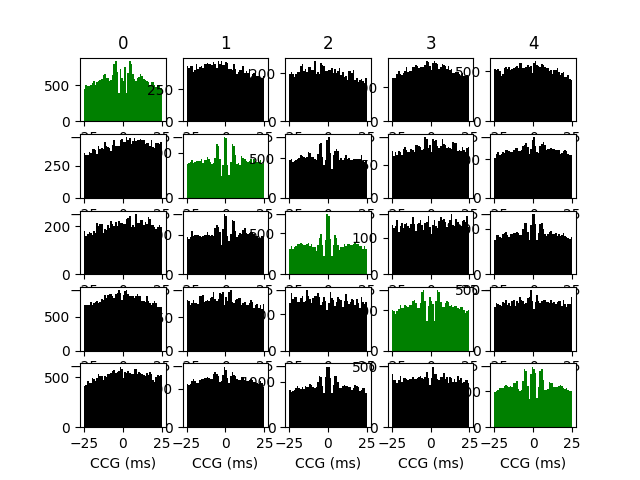

In [54]:
si.compute_correlograms(waveforms)
si.plot_crosscorrelograms(waveforms, bad_units_ids[:5])

# Auto merge (Lussac module)

Eventually, you can have a list of putative merges that should be done (and could be done)

In [55]:
si.get_potential_auto_merge(waveforms)

[]

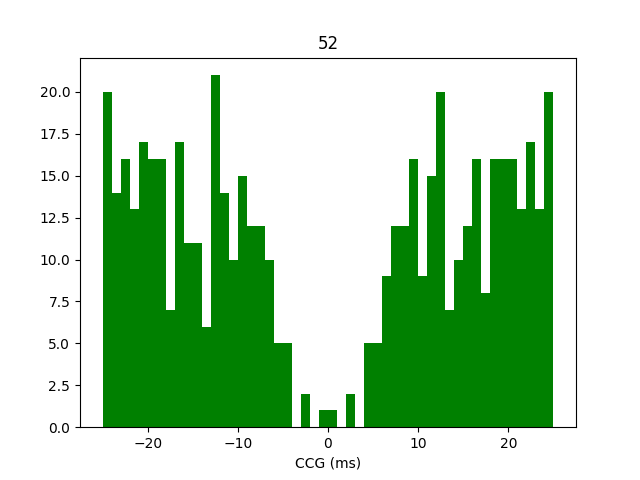

In [56]:
si.plot_crosscorrelograms(waveforms, good_units_ids[:5])

extract amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

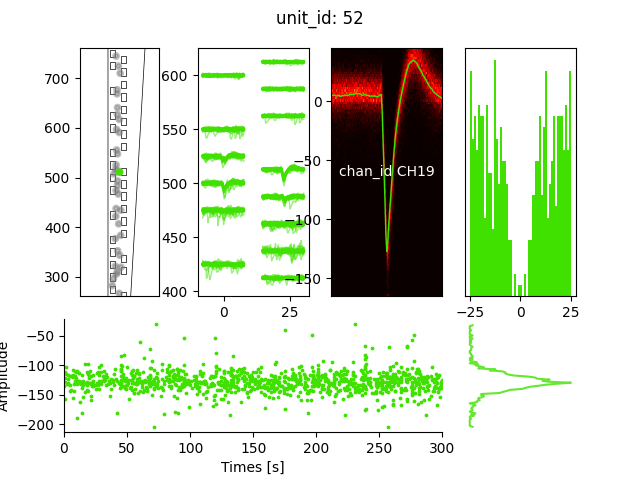

In [57]:
si.compute_unit_locations(waveforms)
si.compute_spike_amplitudes(waveforms, **job_kwargs)
si.plot_unit_summary(waveforms, good_units_ids[0])

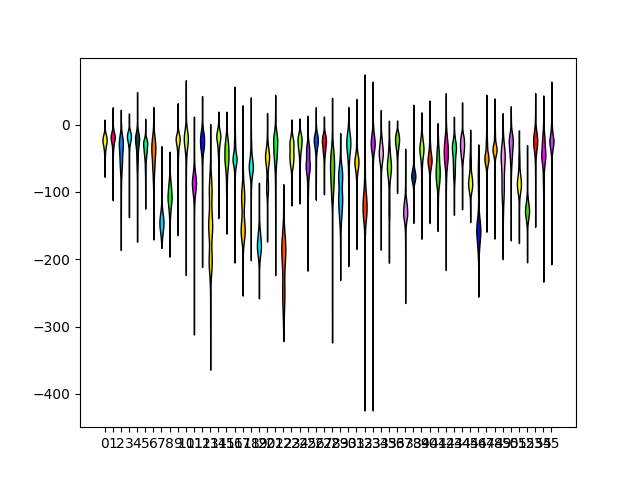

In [58]:
si.plot_all_amplitudes_distributions(waveforms)

In [59]:
%matplotlib widget
si.plot_unit_templates(waveforms, backend='ipywidgets')

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

In [60]:
recording, gt_sorting = si.generate_ground_truth_recording(num_channels=64,
                                                           num_units=100,
                                                           durations=[300.],
                                                           seed=42)

In [62]:
results_2 = si.run_sorter('spykingcircus2', recording, output_folder='toy', verbose=True, remove_existing_folder=True)

detect peaks using locally_exclusive with n_jobs = 20 and chunk_size = 25000


detect peaks using locally_exclusive:   0%|          | 0/300 [00:00<?, ?it/s]

We found 162487 peaks in total
We kept 162487 peaks for clustering
extracting features with n_jobs = 20 and chunk_size = 25000


extracting features:   0%|          | 0/300 [00:00<?, ?it/s]

We found 128 raw clusters, starting to clean with matching...
extract waveforms shared_memory multi buffer with n_jobs = 20 and chunk_size = 25000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer with n_jobs = 20 and chunk_size = 25000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

We kept 54 non-duplicated clusters...
extract waveforms shared_memory multi buffer with n_jobs = 20 and chunk_size = 25000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer with n_jobs = 20 and chunk_size = 25000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

find spikes (circus-omp-svd) with n_jobs = 20 and chunk_size = 2500


find spikes (circus-omp-svd):   0%|          | 0/3000 [00:00<?, ?it/s]

We found 234569 spikes
spykingcircus2 run time 57.74s


In [63]:
waveforms_bis = si.extract_waveforms(recording, results_2, mode='memory', sparse=True, **job_kwargs, ms_before=2, ms_after=2)

extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

In [64]:
si.get_potential_auto_merge(waveforms_bis)

[(3, 41), (9, 11)]

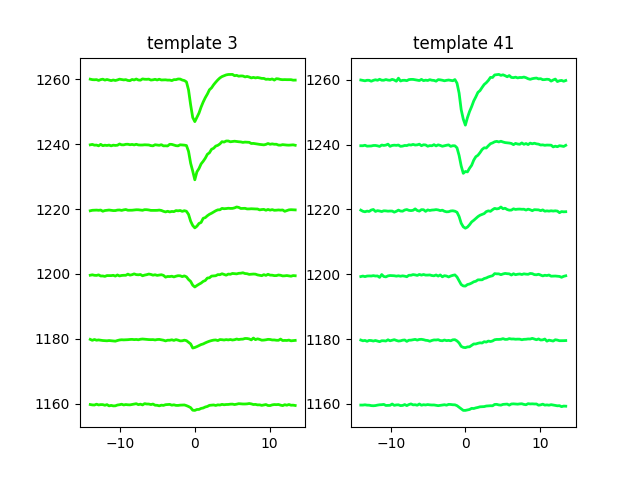

In [65]:
si.plot_unit_templates(waveforms_bis, unit_ids=[3, 41])

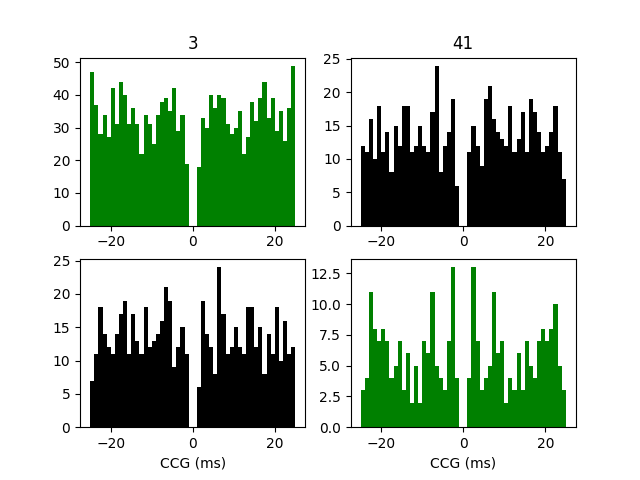

In [67]:
si.compute_correlograms(waveforms_bis)
si.plot_crosscorrelograms(waveforms_bis, unit_ids=[3, 41])

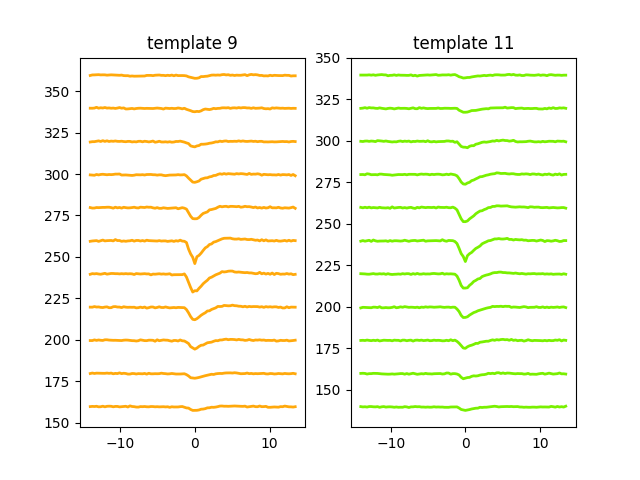

In [68]:
si.plot_unit_templates(waveforms_bis, unit_ids=[9, 11])